<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Text2PixelAnimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Text2PixelAnimation</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [CLIP](https://github.com/openai/CLIP), [Pixray](https://github.com/dribnet/pixray)

Creators: **[dribnet](https://github.com/dribnet), [altsoph](https://twitter.com/altsoph)**

Colab based on altsoph's [notebook](https://colab.research.google.com/github/altsoph/clipit/blob/master/demos/Pixray_Swirl_Demo.ipynb).

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@MLArt](https://t.me/MLArt),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>

#@markdown (Eng) Setup can take 3-7 minutes. Wait until the end of the execution and follow the further instructions.

#@markdown (Rus) Установка может занять 3-7 минут. Дождитесь окончания выполнения и следуйте дальнейшей инструкции.

# https://stackoverflow.com/a/56727659/1010653

print('Wait a few minutes for all the required libraries to be installed.')

try: 
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
except: pass

from IPython.display import clear_output

# Add a gpu check
# (this can get better over time)
from google.colab import output

nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  warning_string = f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, THIS IS PROBABLY NOT ENOUGH <--"
  print(warning_string)
  output.eval_js('alert("Warning - low GPU (see message)")')
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

from IPython.utils import io
with io.capture_output() as captured:
  # On 2021/10/08, Colab updated its default PyTorch installation to a version that causes
  # problems with diffvg. So, first thing, let's roll back to the older version:
  !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch/ -f https://download.pytorch.org/whl/torchvision/
  !apt-get install libmagickwand-dev
  !pip install wand

  !git clone https://github.com/openai/CLIP
  # !pip install taming-transformers
  !git clone https://github.com/CompVis/taming-transformers.git
  !rm -Rf pixray
  !git clone --branch v1.1 https://github.com/dribnet/pixray
  !pip install ftfy regex tqdm omegaconf pytorch-lightning
  !pip install kornia
  !pip install imageio-ffmpeg   
  !pip install einops
  !pip install torch-optimizer
  !pip install easydict
  !pip install braceexpand
  !pip install git+https://github.com/pvigier/perlin-numpy

  # ClipDraw deps
  !pip install svgwrite
  !pip install svgpathtools
  !pip install cssutils
  !pip install numba
  !pip install torch-tools
  !pip install visdom

  !git clone https://github.com/BachiLi/diffvg
  %cd diffvg
  # !ls
  !git submodule update --init --recursive
  !python setup.py install
  %cd ..

output.clear()
import sys
import shutil
import numpy as np
import random
from wand.image import Image as WImage
from PIL import ImageFile, Image, PngImagePlugin, ImageDraw
sys.path.append("pixray")

def intpc(c1,c2,w):
    r = []
    for a,b in zip(c1,c2):
        r.append( int( a*w+b*(1.-w) ) )
    return tuple(r)

def swirlit2(img, rot, rot2, rs=None, shift=None, cell_size=5, alpha=1., noise_prob=0.1):
    work_img = np.array(img) # .copy()
    s_x, s_y = work_img.shape[1], work_img.shape[0]

    img_res = Image.new(mode="RGB", size=(s_x, s_y), color=(255, 255, 255))
    img_res_draw = ImageDraw.Draw(img_res)
    # make random background
    for y in range(0,s_y,cell_size):
        for x in range(0,s_x,cell_size):
            cc = (int(random.random()*255),int(random.random()*255),int(random.random()*255))
            img_res_draw.rectangle( (x,y,x+cell_size, y+cell_size), fill=cc, outline=cc  )

    # put background
    if rs:
        tmp_bg1 = img.resize(rs)
    else:
        tmp_bg1 = img.copy()
        rs = (s_x, s_y)
    tmp_bg = Image.new(mode="RGB", size=(s_x, s_y), color=(255, 255, 255))
    if shift:
        tmp_bg.paste(tmp_bg1, shift)
    else:
        tmp_bg.paste(tmp_bg1, (0,0))
        shift = (0,0)

    # make swirl        
    wimg = WImage.from_array(np.array(tmp_bg))
    wimg.virtual_pixel = 'transparent'
    wimg.swirl(degree=rot)
    wimg.virtual_pixel = 'transparent'
    wimg.rotate(rot2, reset_coords=False)

    tmp_bg = Image.fromarray(np.array(wimg))
    for y in range(s_y):
        for x in range(s_x):
            if shift[0]<=x<rs[0]+shift[0] and\
                   shift[1]<=y<rs[1]+shift[1] and\
                   tmp_bg.getpixel((x,y))[-1] != 0 and tmp_bg.getpixel((x,y))[:3] != (255,255,255):
                img_res.putpixel((x,y),
                    intpc(tmp_bg.getpixel((x,y)),img_res.getpixel((x,y)),alpha)
                )

    # add random over foreground
    for y in range(0,s_y,cell_size):
        for x in range(0,s_x,cell_size):
            if random.random()<noise_prob:
                cc = (int(random.random()*255),int(random.random()*255),int(random.random()*255))
                img_res_draw.rectangle( (x,y,x+cell_size, y+cell_size), fill=cc, outline=cc  )

    return img_res



result_msg = "setup complete"
import IPython
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  result_msg = "Please choose Runtime -> Restart Runtime from the menu, and then run Setup again"

js_code = f'''
document.querySelector("#output-area").appendChild(document.createTextNode("{result_msg}"));
'''
js_code += '''
for (rule of document.styleSheets[0].cssRules){
  if (rule.selectorText=='body') break
}
rule.style.fontSize = '30px'
'''
display(IPython.display.Javascript(js_code))

<b>(Eng) <font color="red" size="+1">Before executing the next block, select "Runtime > Restart runtime" (from the top of the menu)</font>

<b>(Rus) <font color="red" size="+1">Перед выполнением следующего блока выберите сверху в меню "Среда выполнения > Перезагрузить среду выполнения" </font>

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> The last step of the installation</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Последний шаг установки</font></b>

import sys
import shutil
import numpy as np
import random
from wand.image import Image as WImage
from PIL import ImageFile, Image, PngImagePlugin, ImageDraw
sys.path.append("pixray")

def intpc(c1,c2,w):
    r = []
    for a,b in zip(c1,c2):
        r.append( int( a*w+b*(1.-w) ) )
    return tuple(r)

def swirlit2(img, rot, rot2, rs=None, shift=None, cell_size=5, alpha=1., noise_prob=0.1):
    work_img = np.array(img) # .copy()
    s_x, s_y = work_img.shape[1], work_img.shape[0]

    img_res = Image.new(mode="RGB", size=(s_x, s_y), color=(255, 255, 255))
    img_res_draw = ImageDraw.Draw(img_res)
    # make random background
    for y in range(0,s_y,cell_size):
        for x in range(0,s_x,cell_size):
            cc = (int(random.random()*255),int(random.random()*255),int(random.random()*255))
            img_res_draw.rectangle( (x,y,x+cell_size, y+cell_size), fill=cc, outline=cc  )

    # put background
    if rs:
        tmp_bg1 = img.resize(rs)
    else:
        tmp_bg1 = img.copy()
        rs = (s_x, s_y)
    tmp_bg = Image.new(mode="RGB", size=(s_x, s_y), color=(255, 255, 255))
    if shift:
        tmp_bg.paste(tmp_bg1, shift)
    else:
        tmp_bg.paste(tmp_bg1, (0,0))
        shift = (0,0)

    # make swirl        
    wimg = WImage.from_array(np.array(tmp_bg))
    wimg.virtual_pixel = 'transparent'
    wimg.swirl(degree=rot)
    wimg.virtual_pixel = 'transparent'
    wimg.rotate(rot2, reset_coords=False)

    tmp_bg = Image.fromarray(np.array(wimg))
    for y in range(s_y):
        for x in range(s_x):
            if shift[0]<=x<rs[0]+shift[0] and\
                   shift[1]<=y<rs[1]+shift[1] and\
                   tmp_bg.getpixel((x,y))[-1] != 0 and tmp_bg.getpixel((x,y))[:3] != (255,255,255):
                img_res.putpixel((x,y),
                    intpc(tmp_bg.getpixel((x,y)),img_res.getpixel((x,y)),alpha)
                )

    # add random over foreground
    for y in range(0,s_y,cell_size):
        for x in range(0,s_x,cell_size):
            if random.random()<noise_prob:
                cc = (int(random.random()*255),int(random.random()*255),int(random.random()*255))
                img_res_draw.rectangle( (x,y,x+cell_size, y+cell_size), fill=cc, outline=cc  )

    return img_res



result_msg = "setup complete"
import IPython
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  result_msg = "Please choose Runtime -> Restart Runtime from the menu, and then run Setup again"

js_code = f'''
document.querySelector("#output-area").appendChild(document.createTextNode("{result_msg}"));
'''
js_code += '''
for (rule of document.styleSheets[0].cssRules){
  if (rule.selectorText=='body') break
}
rule.style.fontSize = '30px'
'''
display(IPython.display.Javascript(js_code))

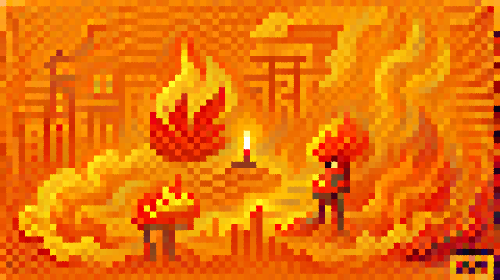

iter: 400, finished (-99=>2.75)


'./very_first_frame.png'

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate first frame</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Сгенерировать первый кадр</font></b>

do_pixel = True #@param {type:"boolean"}

text = "\u0413\u043E\u0440\u044F\u0449\u0438\u0439 \u043E\u0433\u043E\u043D\u044C" #@param {type:"string"}
try:
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
  translation = translator.translate(text)
  new_text = translation.text
except: new_text = text
if do_pixel: prompts = new_text + ' #pixelart #8bit'
else: prompts = new_text

iteration = 200 #@param {type:"integer"}
aspect = "widescreen" #@param ["widescreen", "square"]
scale = 2.5 #@param {type:"slider", min:1, max:8, step:0.25}
smoothness = True #@param {type:"boolean"} 
saturation = True #@param {type:"boolean"} 

#@markdown ---
#@markdown (ENG) Specify the desired palette. Examples below 

#@markdown (RUS) Укажите желаемую цветовую палитру. Примеры ниже:
#@markdown * <font color="red">red</font> (16 color black to red ramp) 
#@markdown * <font color="red">rust\8</font>  (8 color black to rust ramp)
#@markdown * <font color="red">black->red->white</font> (16 color black/red/white ramp)
#@markdown * <font color="red">[#000000, #ff0000, #ffff00, #000080]</font> (four colors)
#@markdown * <font color="red">red->yellow;[black]</font>     (16 colors from ramp and also black)
#@markdown * (or leave **use_palette** blank for default palette settings)

#@markdown (ENG) Named colors can be anything in <a target=”_blank” href="https://xkcd.com/color/rgb/">this lookup table</a>

#@markdown (RUS) Имена цветов могут быть любыми из <a target=”_blank” href="https://xkcd.com/color/rgb/">этой таблицы</a>

use_palette = "red->yellow" #@param {type:"string"}


# Simple setup
import pixray

# these are good settings for pixeldraw
pixray.reset_settings()
pixray.add_settings(prompts=prompts, aspect=aspect)
pixray.add_settings(quality="better", scale=scale)
pixray.add_settings(display_clear=True)

if do_pixel:
  pixray.add_settings(drawer="pixel")

# palette = None
if use_palette and use_palette!='None' and use_palette!='':
  pixray.add_settings(target_palette=use_palette)

if smoothness and smoothness!='None':
  pixray.add_settings(smoothness=2.0, smoothness_type='log')

if saturation:
  pixray.add_settings(saturation=1.0)

pixray.add_settings(noise_prompt_seeds=[1,2,3])

pixray.add_settings(iterations=iteration, display_every=50)

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)

shutil.copy('./output.png', './very_first_frame.png')

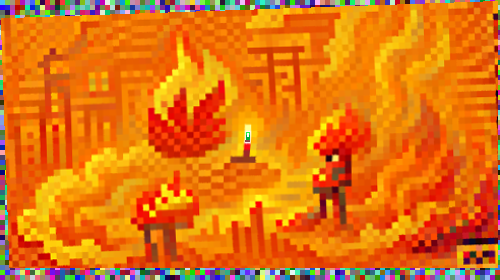

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Adjust the distortion to be applied to each frame</font></b> {run: "auto"}
#@markdown <b><font color="black" size="+1"> (RUS) Настройте искажение, которое будет применяться к каждому кадру</font></b>

outer_rotation =  -2 #@param {type:"integer"}
inner_rotation =  -4 #@param {type:"integer"}
zoom = -4 #@param {type:"integer"}
shift_x =  -10 #@param {type:"integer"}
shift_y =  -20 #@param {type:"integer"}


swirlit2(Image.open('./very_first_frame.png'),
         rot=inner_rotation,\
         rot2=outer_rotation,\
         rs=(500-zoom*2,280-zoom*2),\
         shift=(shift_x,shift_y),\
         noise_prob=0.)

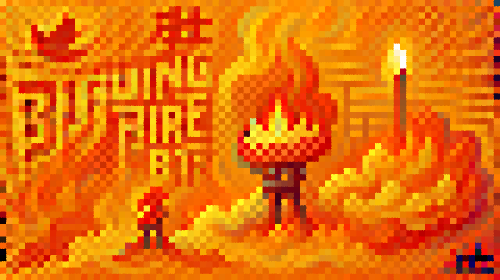

iter: 300, finished (-67=>2.568)


'./frame_030.png'

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Start generating the remaining frames (this can take quite a long time)</font></b> {run: "auto"}
#@markdown <b><font color="black" size="+1"> (RUS) Запустить генерацию оставшихся кадров (это может занять достаточно много времени)</font></b>

frames2generate = 30 #@param {type:"integer"}
iteration_per_frame = 200 #@param {type:"integer"}

import shutil
shutil.copy('./very_first_frame.png', f'./frame_{0:03d}.png')
s = 1
for frame in range(frames2generate):
    if frame: shutil.copy('./output.png', f'./frame_{frame:03d}.png')
    swirlit2(Image.open(f'./frame_{frame:03d}.png'),
         rot=inner_rotation,\
         rot2=outer_rotation,\
         rs=(500-zoom*2,280-zoom*2),\
         shift=(shift_x,shift_y),\
         noise_prob=0.).save('./cur_seed.png')

    pixray.reset_settings()
    pixray.add_settings(prompts=prompts, aspect=aspect)
    pixray.add_settings(quality="better", scale=scale)
    pixray.add_settings(iterations=iteration_per_frame//s)
    pixray.add_settings(display_clear=True)
    pixray.add_settings(init_image='./cur_seed.png')
    if do_pixel:
      pixray.add_settings(drawer="pixel")
    if use_palette and use_palette!='None':
      pixray.add_settings(target_palette=use_palette, enforce_palette_annealing=5000//s)
    if smoothness and smoothness!='None':
      pixray.add_settings(smoothness=2.0*s, smoothness_type='log')
    if saturation:
      if s == 1:
        pixray.add_settings(saturation=1.)
      else:
        pixray.add_settings(saturation=.5*s)

    settings = pixray.apply_settings()
    pixray.do_init(settings)
    pixray.do_run(settings)

shutil.copy('./output.png', f'./frame_{frames2generate:03d}.png')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Compile the resulting movie clip</font></b> {run: "auto"}
#@markdown <b><font color="black" size="+1"> (RUS) Собрать получившийся фрагмент ролика</font></b>

#@title Compile the resulting movie clip
from tqdm.notebook import tqdm
from subprocess import Popen, PIPE

fps = 8 #@param

frames = []
for frame in range(0,frames2generate):
  try:
    frames.append(Image.open(f'./frame_{frame:03d}.png'))
  except: pass

p = Popen(['ffmpeg',
           '-y',
           '-f', 'image2pipe',
           '-vcodec', 'png',
           '-r', str(fps),
           '-i',
           '-',
           '-vcodec', 'libx264',
           '-r', str(fps),
           '-pix_fmt', 'yuv420p',
           '-crf', '17',
           '-preset', 'veryslow',
           'swirl.mp4'], stdin=PIPE)

for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()
p.wait()

from IPython.display import HTML
from base64 import b64encode
mp4 = open('swirl.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download result</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать результат</font></b>

from google.colab import files
files.download('swirl.mp4')